In [1]:
import numpy as np
import pandas as pd
import seaborn.objects as so
from formulaic import Formula
from sklearn import linear_model  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

**Este proyecto analiza la repitencia en los niveles primario y secundario del Área Metropolitana a partir de datos educativos agregados y otros complementarios. Se realiza un análisis exploratorio general y por zona, junto con un modelado predictivo mediante regresión Ridge y validación temporal, destacando las limitaciones asociadas a cambios estructurales post pandemia.**

**ANALISIS EXPLORATORIO POR ZONAS - AREA METROPOLITANA (2022)**

In [2]:
df_educacion = pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\indicadores-proceso-trayectoria-sobreedad-2012_2022.csv")
df_poblacion=pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\proyecciones-poblacion-2010_2025.csv")
df_transferencias=pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\transferencias-municipios-012010_072025.csv")
df_servicio=pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\evolucion-unidades-de-servicio-y-matricula-2011_2023.csv")

In [3]:
area_metropolitana = [
    "Almirante Brown", "Avellaneda", "Berazategui", "Berisso", "Brandsen", "Campana", "Cañuelas",
    "Ensenada", "Escobar", "Esteban Echeverria", "Exaltacion de la Cruz", "Ezeiza",
    "Florencio Varela", "General Las Heras", "General Rodriguez", "General San Martin", "Hurlingham",
    "Ituzaingo", "Jose C. Paz", "La Matanza", "La Plata", "Lanus", "Lujan", "Lomas de Zamora",
    "Malvinas Argentinas", "Marcos Paz", "Merlo", "Moreno", "Moron", "Pilar", "Presidente Peron",
    "Quilmes", "San Fernando", "San Isidro", "San Miguel", "San Vicente", "Tigre", "Tres de Febrero",
    "Vicente Lopez", "Zarate"
]

zona_norte = ['San Isidro', 'Vicente Lopez', 'General San Martin', 'San Fernando', 'Tigre']
zona_oeste = ['Moron', 'Tres de Febrero', 'La Matanza', 'Merlo', 'Moreno']
zona_sur = ['Almirante Brown', 'Avellaneda', 'Quilmes', 'Lanus', 'Florencio Varela', 'Berazategui', 'Lomas de Zamora', 'Esteban Echeverria']

In [4]:
df_educacion=df_educacion[df_educacion["municipio_nombre"].isin(area_metropolitana)].reset_index(drop=True)

def determinar_zona(x):
    if x in zona_norte:
        return 'Norte'
    elif x in zona_oeste:
        return 'Oeste'
    elif x in zona_sur:
        return 'Sur'
    else:
        return 'Interior'
    
df_educacion["Zona"]=df_educacion["municipio_nombre"].apply(determinar_zona)

In [5]:
df_analisis_2022=df_educacion[df_educacion["anio"]==2022].copy()

#Transferencias
df_transferencias_2022=df_transferencias[df_transferencias["anio"]==2022]
df_transferencias_2022=df_transferencias_2022[df_transferencias_2022["municipio_nombre"].isin(area_metropolitana)]

transferencias_educacion=df_transferencias_2022[df_transferencias_2022["concepto"].isin(["Fondo Financiamiento Educativo"])]
transferencias_educacion=transferencias_educacion.rename(columns={"monto":"inversion_educacion"})
transferencias_educacion=transferencias_educacion[["municipio_nombre","inversion_educacion"]]

df_transferencias_2022=df_transferencias_2022.groupby("municipio_nombre")["monto"].sum().reset_index()
df_transferencias_2022=df_transferencias_2022.rename(columns={"monto":"inversion_total"})

df_transferencias_2022=pd.merge(df_transferencias_2022,transferencias_educacion,on="municipio_nombre",how="inner")

#Poblacion
df_poblacion_2022=df_poblacion[df_poblacion["municipio_nombre"].isin(area_metropolitana)]
df_poblacion_2022=df_poblacion_2022[["municipio_nombre","2022"]]
df_poblacion_2022=df_poblacion_2022.rename(columns={"2022":"poblacion"})

#Cantidad de colegios 
df_colegios_2022=df_servicio[df_servicio["municipio_nombre"].isin(area_metropolitana)]
df_colegios_2022=df_colegios_2022[df_colegios_2022["anio"]==2022]
df_colegios_2022=df_colegios_2022[["unidades_de_servicio_nivel_primario","matricula_nivel_primario*******","matricula_nivel_inicial","matricula_nivel_secundario********","unidades_de_servicio_nivel_secundario**","municipio_nombre"]]
df_colegios_2022=df_colegios_2022.rename(columns={"unidades_de_servicio_nivel_primario":"colegios_primario","unidades_de_servicio_nivel_secundario**":"colegios_secundario",
                                                  "matricula_nivel_primario*******":"matricula_primario","matricula_nivel_secundario********":"matricula_secundario"})

#Junto los data frame
df_analisis_2022=pd.merge(df_analisis_2022,df_transferencias_2022,on="municipio_nombre",how="inner")
df_analisis_2022=pd.merge(df_analisis_2022,df_poblacion_2022,on="municipio_nombre",how="inner")
df_analisis_2022=pd.merge(df_analisis_2022,df_colegios_2022,on="municipio_nombre",how="inner")

df_analisis_2022.head()


,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,sobreedad_avanzada_secundaria,Zona,inversion_total,inversion_educacion,poblacion,colegios_primario,matricula_primario,matricula_nivel_inicial,matricula_secundario,colegios_secundario
0,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,1.182079e+08,584827.0,137.0,61498.0,22523.0,52348.0,137.0
1,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,1.296474e+08,584827.0,137.0,61498.0,22523.0,52348.0,137.0
2,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,1.334605e+08,584827.0,137.0,61498.0,22523.0,52348.0,137.0
3,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,7.626316e+07,584827.0,137.0,61498.0,22523.0,52348.0,137.0
4,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,8.007632e+07,584827.0,137.0,61498.0,22523.0,52348.0,137.0


In [6]:
df_zonas_2022=df_analisis_2022.groupby("Zona")[["poblacion","matricula_nivel_inicial","matricula_primario","matricula_secundario","repitencia_primaria","repitencia_secundaria","inversion_educacion","inversion_total","colegios_primario","colegios_secundario","sobreedad_primaria","sobreedad_secundaria","sobreedad_avanzada_primaria","sobreedad_avanzada_secundaria"]].mean().reset_index()
df_zonas_2022

,Zona,poblacion,matricula_nivel_inicial,matricula_primario,matricula_secundario,repitencia_primaria,repitencia_secundaria,inversion_educacion,inversion_total,colegios_primario,colegios_secundario,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,Interior,203206.866667,8594.466667,22467.800000,18589.266667,2.019333,6.523333,3.593174e+07,5.055326e+09,57.600000,51.066667,4.068000,20.844667,0.637333,7.020667
1,Norte,305282.333333,12599.000000,29341.333333,26424.000000,1.460000,4.650000,4.245222e+07,7.305383e+09,85.333333,76.333333,3.320000,18.510000,0.503333,5.773333
2,Oeste,841135.250000,27003.000000,81654.750000,67260.000000,3.195000,5.762500,1.361237e+08,1.659346e+10,168.500000,160.000000,6.070000,20.765000,1.182500,6.595000
3,Sur,521899.500000,20032.333333,55117.500000,46624.833333,3.148333,6.611667,8.892495e+07,9.896553e+09,124.000000,118.333333,5.523333,22.770000,1.073333,8.103333


**ANALISIS EXPLORATORIO POR ZONAS - AREA METROPOLITANA (2022)**

***CONTEXTO***

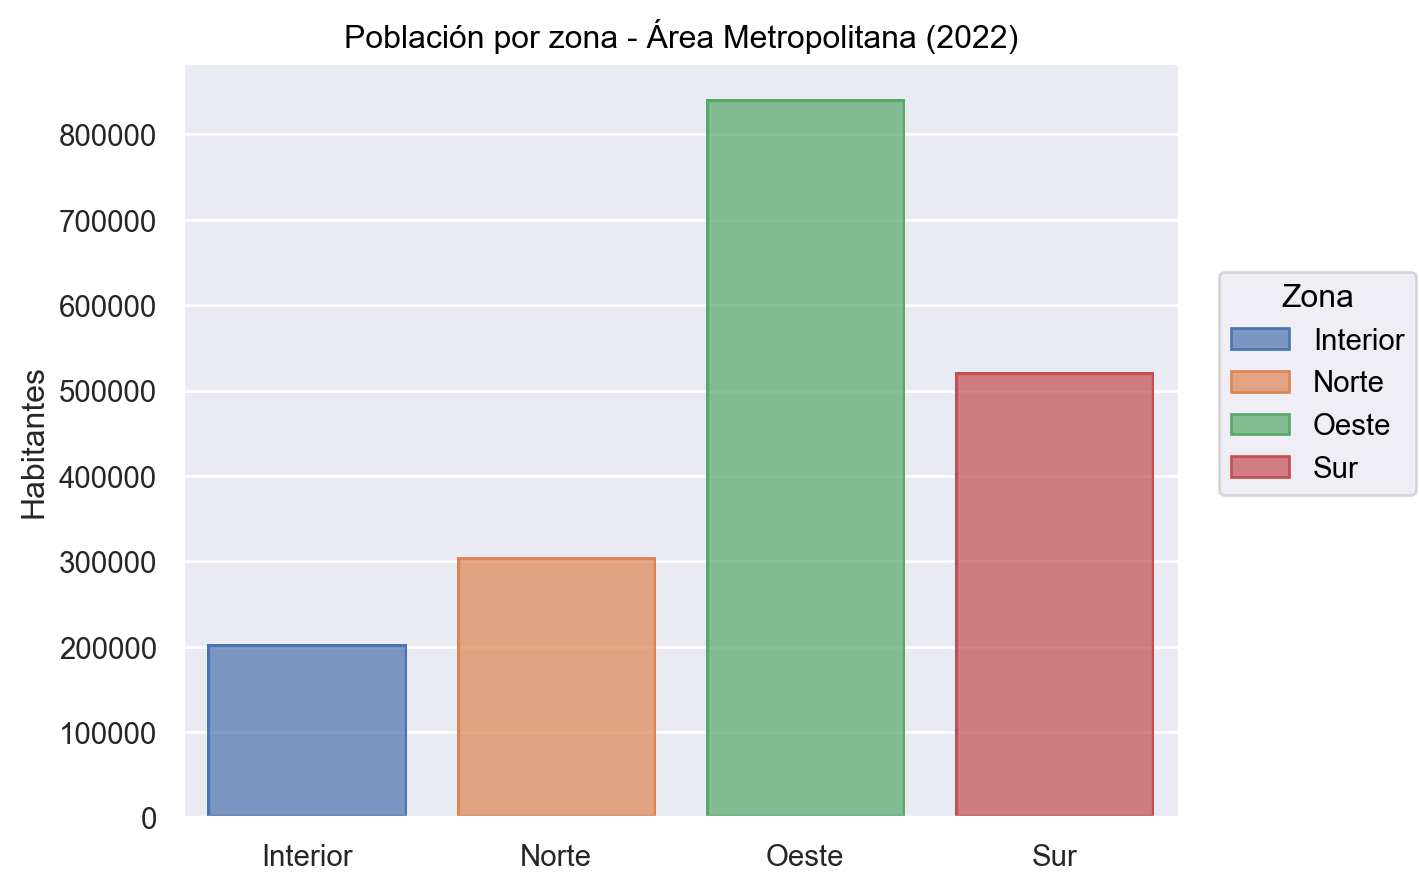

In [7]:
(so.Plot(df_zonas_2022,x="Zona",y="poblacion",color="Zona")
    .add(so.Bar())
    .label(title="Población por zona - Área Metropolitana (2022)",x=None,y="Habitantes"))

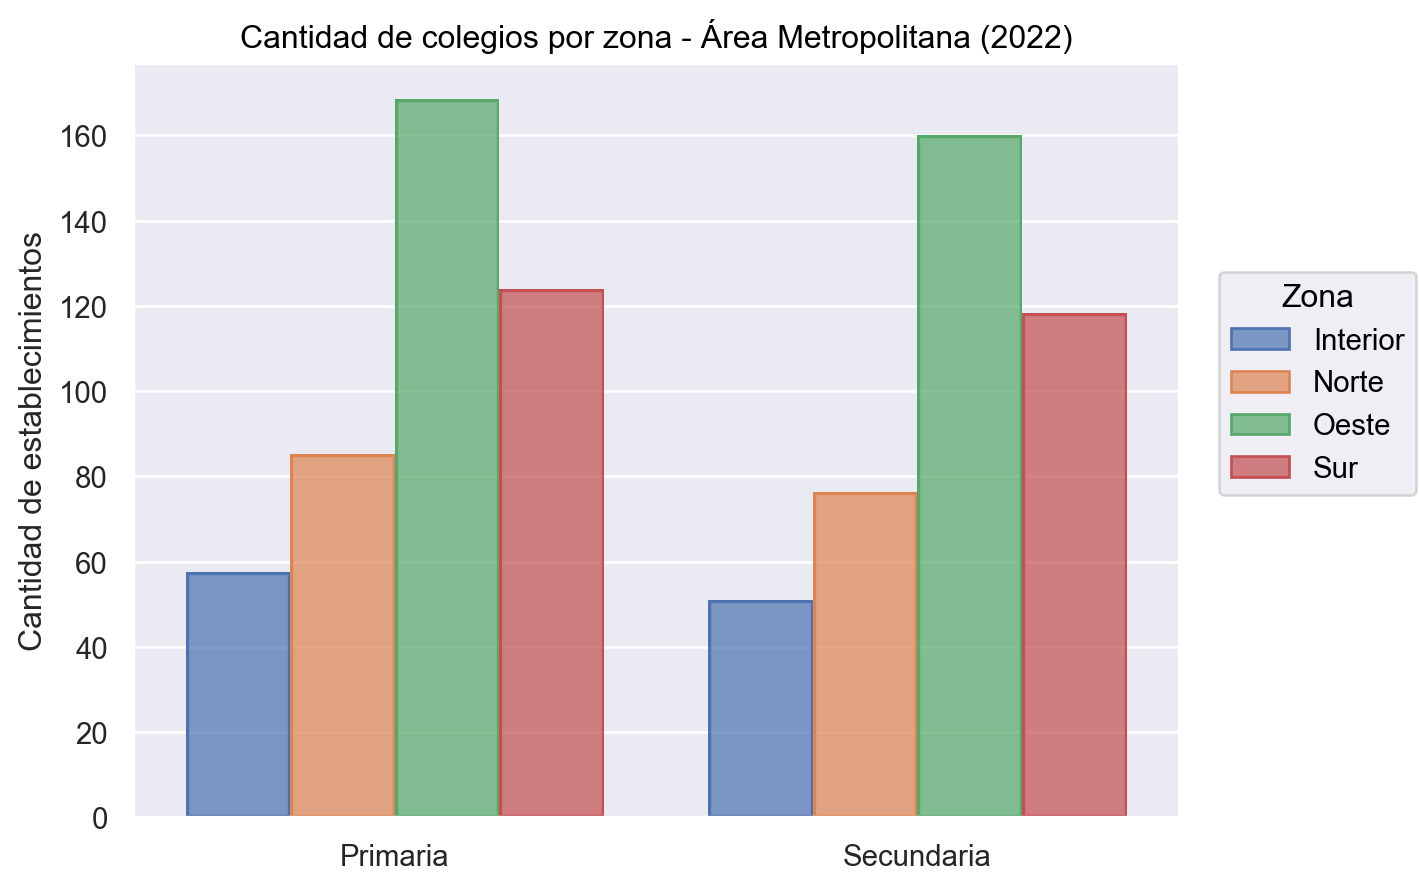

In [8]:
grafico_zona_colegio=df_zonas_2022.copy()
grafico_zona_colegio=grafico_zona_colegio.rename(columns={"colegios_primario":"Primaria","colegios_secundario":"Secundaria"})

grafico_zona_colegio=grafico_zona_colegio.melt(id_vars="Zona",
                                               value_vars=["Primaria","Secundaria"],
                                               var_name="Nivel",
                                               value_name="cantidad_colegios")

(so.Plot(grafico_zona_colegio,x="Nivel",y="cantidad_colegios",color="Zona")
    .add(so.Bar(),so.Dodge())
    .label(title="Cantidad de colegios por zona - Área Metropolitana (2022)",x=None,y="Cantidad de establecimientos"))

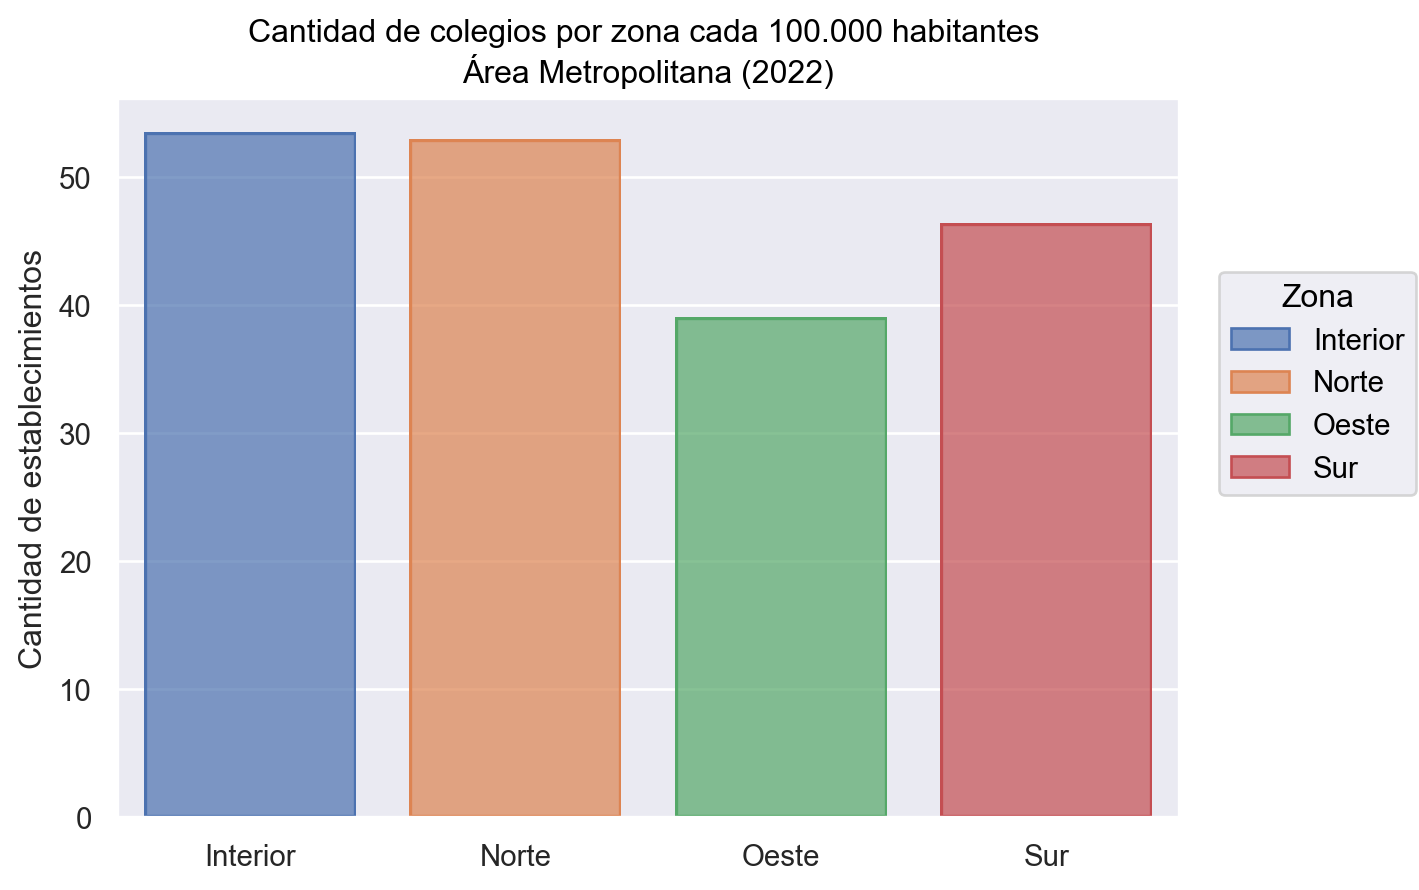

In [9]:
colegios_por_zona=((df_zonas_2022["colegios_secundario"]+df_zonas_2022["colegios_primario"])/df_zonas_2022["poblacion"])*100000

(so.Plot(df_zonas_2022,x="Zona",y=colegios_por_zona,color="Zona")
    .add(so.Bar())
    .label(title="Cantidad de colegios por zona cada 100.000 habitantes \nÁrea Metropolitana (2022)",x=None,y="Cantidad de establecimientos"))

***RECURSOS***

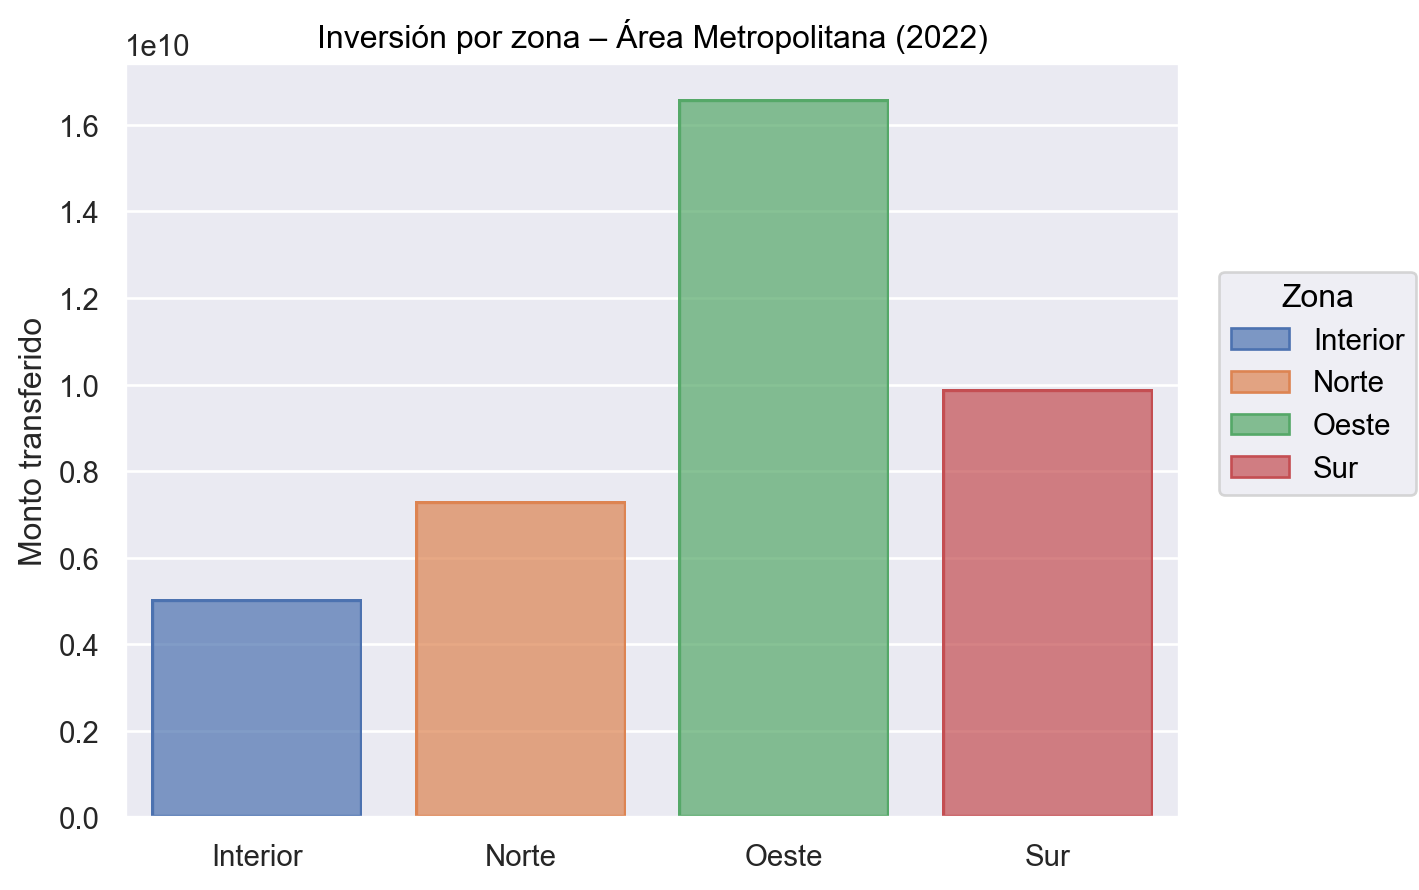

In [10]:
(so.Plot(df_zonas_2022,x="Zona",y="inversion_total",color="Zona")
    .add(so.Bar())
    .label(title="Inversión por zona – Área Metropolitana (2022)",x=None,y="Monto transferido"))

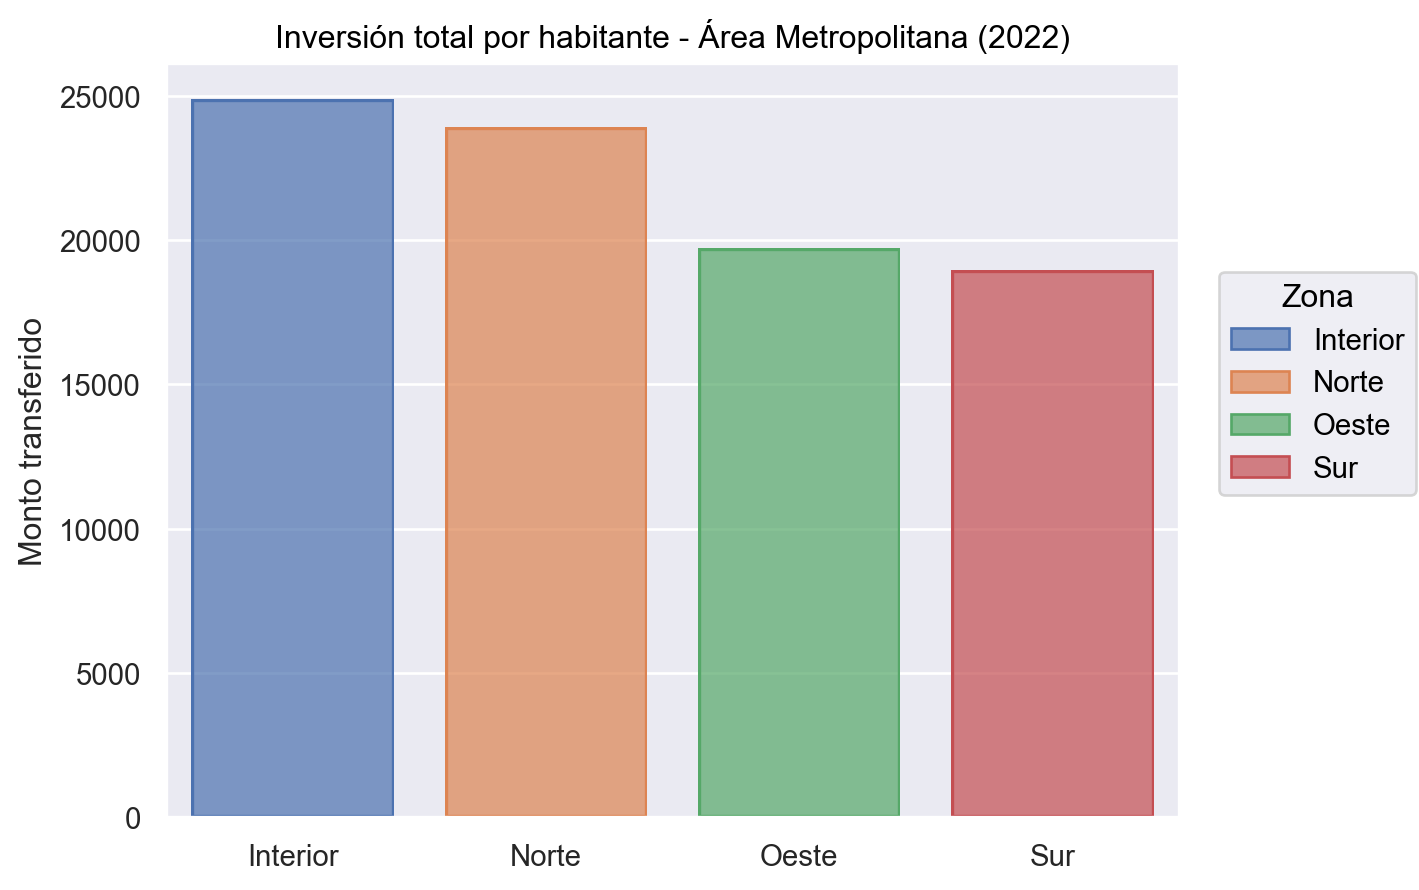

In [11]:
invserion_cada_100000=(df_zonas_2022["inversion_total"]/df_zonas_2022["poblacion"])

(so.Plot(df_zonas_2022,x="Zona",y=invserion_cada_100000,color="Zona")
    .add(so.Bar())
    .label(title="Inversión total por habitante - Área Metropolitana (2022)",x=None,y="Monto transferido"))

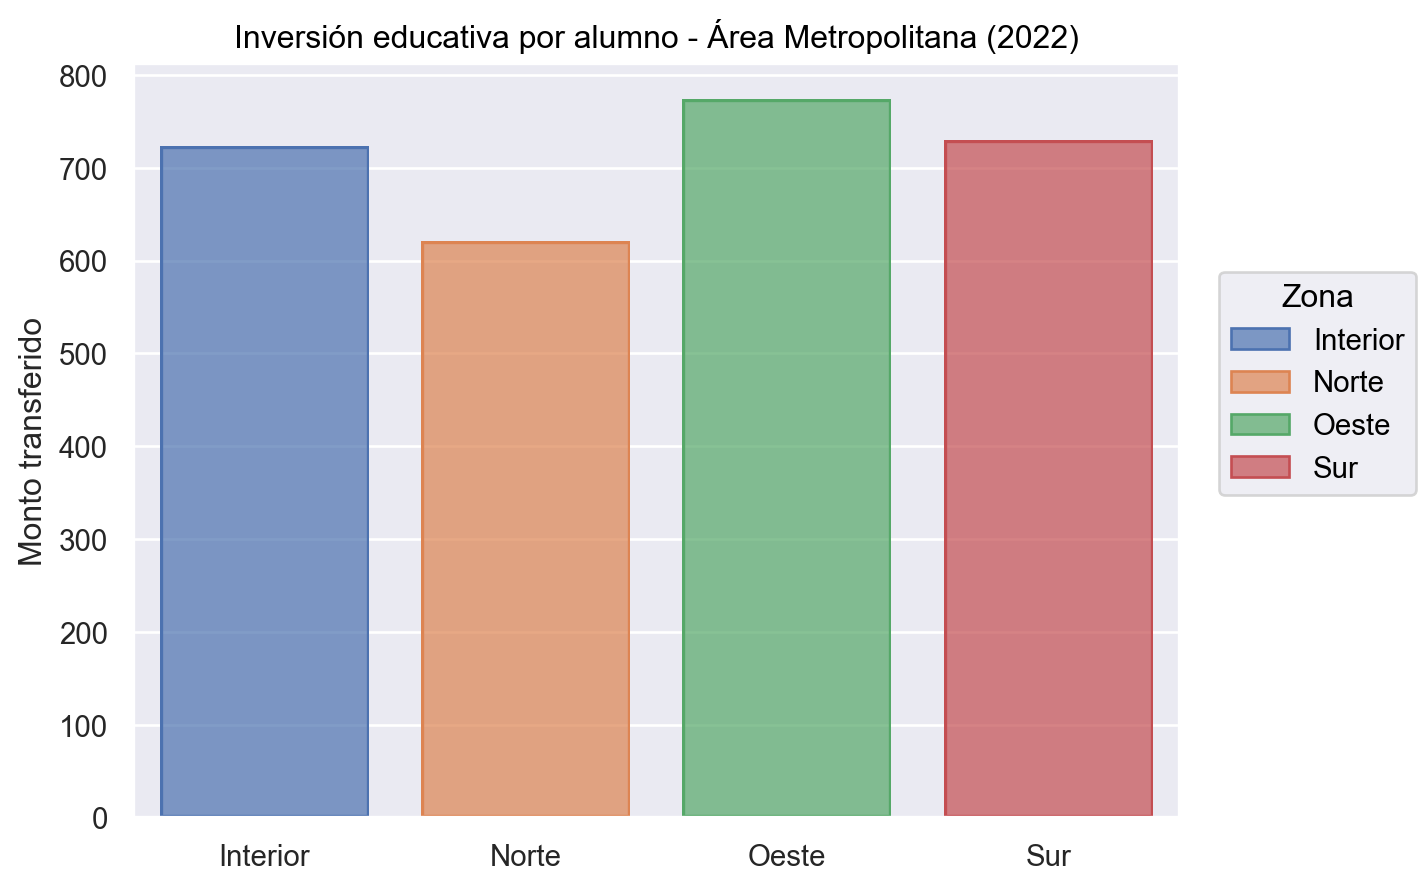

In [12]:
grafico_inversion_estudiante=((df_zonas_2022["inversion_educacion"])/(df_zonas_2022["matricula_primario"]+df_zonas_2022["matricula_nivel_inicial"]+df_zonas_2022["matricula_secundario"]))

(so.Plot(df_zonas_2022,x="Zona",y=grafico_inversion_estudiante,color="Zona")
    .add(so.Bar())
    .label(title="Inversión educativa por alumno - Área Metropolitana (2022)",x=None,y="Monto transferido"))    

***RESULTADO***

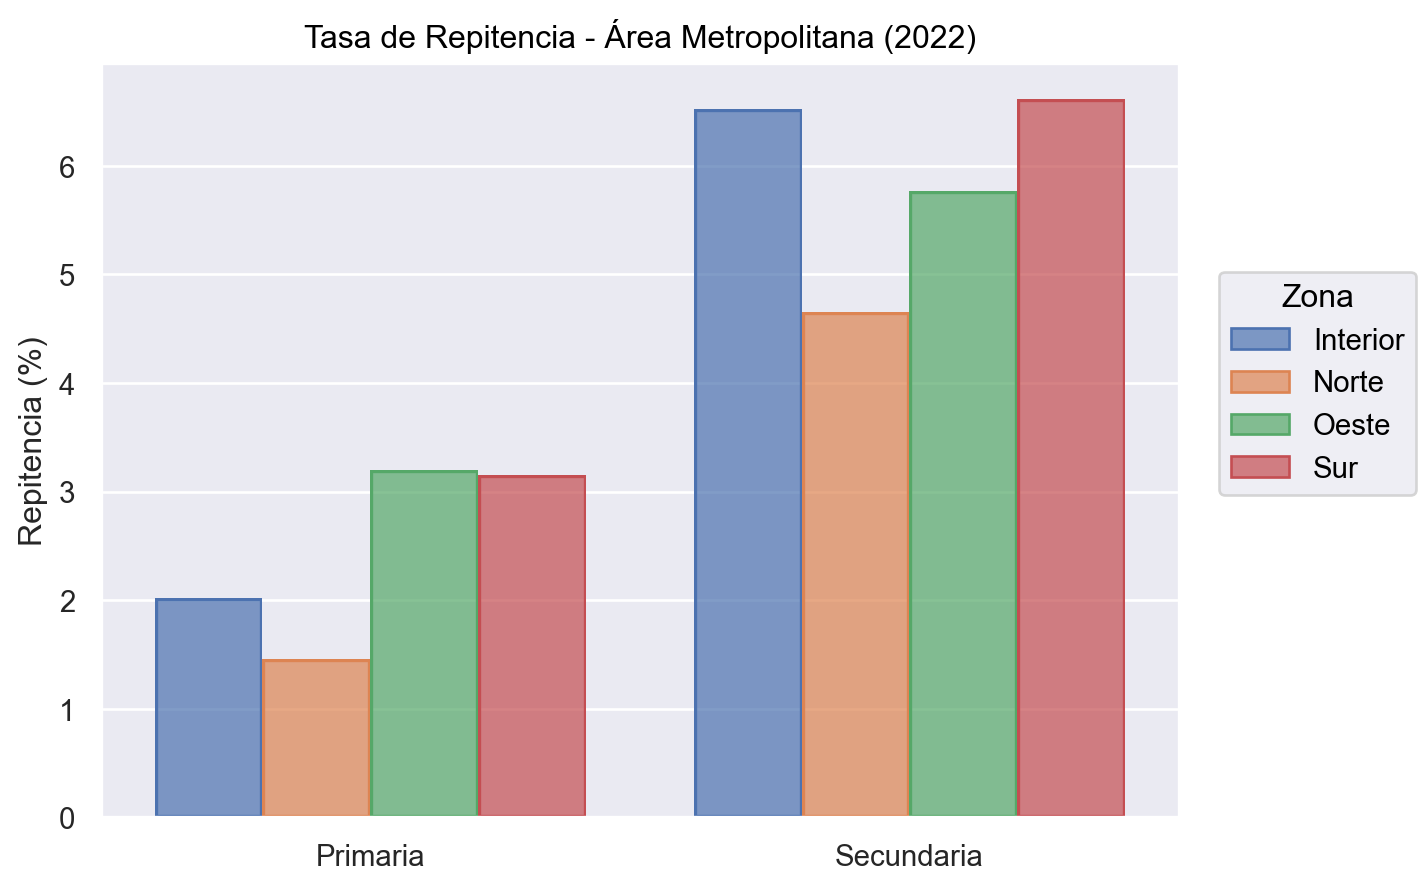

In [13]:
grafico_zona_repitencia=df_zonas_2022.copy()
grafico_zona_repitencia=grafico_zona_repitencia.rename(columns={"repitencia_secundaria":"Secundaria","repitencia_primaria":"Primaria"})
grafico_zona_repitencia=grafico_zona_repitencia.melt(id_vars="Zona",
                                            value_vars=["Primaria","Secundaria"],
                                            var_name="nivel_educativo",
                                            value_name="taza_repitencia")

(so.Plot(grafico_zona_repitencia,x="nivel_educativo",y="taza_repitencia",color="Zona")
    .add(so.Bar(),so.Dodge())
    .label(title="Tasa de Repitencia - Área Metropolitana (2022)",x=None,y="Repitencia (%)"))

**PROYECTO ANALITICO - ANALISIS DE REPITENCIA NIVEL PRIMARIO Y SECUNDARIO EN EL AREA METROPOLITANA (2013-2022)**

***POBLACION***

In [14]:
df_poblacion=df_poblacion[df_poblacion["municipio_nombre"].isin(area_metropolitana)]
df_poblacion=df_poblacion.loc[:,"2013":"2022"].sum().reset_index().rename(columns={"index":"anio",0:"poblacion"})
df_poblacion=df_poblacion.astype(int)

df_poblacion.head()

,anio,poblacion
0,2013,9821915
1,2014,9966956
2,2015,10110100
3,2016,10250999
4,2017,10390219


***SERVICIO***

In [15]:
df_servicio=df_servicio.dropna()
df_servicio=df_servicio.groupby("anio")[["matricula_nivel_inicial","unidades_de_servicio_nivel_primario","unidades_de_servicio_nivel_secundario**",
                             "matricula_nivel_primario*******","matricula_nivel_secundario********"]].sum().reset_index()

df_servicio["colegios_primario"]=df_servicio["matricula_nivel_primario*******"]/df_servicio["unidades_de_servicio_nivel_primario"]
df_servicio["colegios_secundario"]=df_servicio["matricula_nivel_secundario********"]/df_servicio["unidades_de_servicio_nivel_secundario**"]

df_servicio=df_servicio[(df_servicio["anio"]>=2013) & (df_servicio["anio"]<=2022)]
df_servicio=df_servicio.astype(int)
df_servicio=df_servicio.rename(columns={"matricula_nivel_primario*******":"matricula_primario","matricula_nivel_secundario********":"matricula_secundario"})
df_servicio.head()

,anio,matricula_nivel_inicial,unidades_de_servicio_nivel_primario,unidades_de_servicio_nivel_secundario**,matricula_primario,matricula_secundario,colegios_primario,colegios_secundario
2,2013,700688,5726,4315,1672887,1281572,292,297
3,2014,712783,5720,4260,1682152,1282527,294,301
4,2015,719889,5725,4216,1690161,1295252,295,307
5,2016,725600,5727,4212,1699661,1313047,296,311
6,2017,737058,5729,4183,1709261,1330950,298,318


***EDUCACION***

In [16]:
df_educacion=df_educacion[df_educacion["municipio_nombre"].isin(area_metropolitana)].reset_index(drop=True)
df_educacion=df_educacion[(df_educacion["anio"]>=2013) & (df_educacion["anio"]<=2022)]
df_educacion=df_educacion.groupby("anio").mean(numeric_only=True).reset_index()

df_educacion.head()

,anio,municipio_id,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,abandono_interanual_secundaria,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,2013,6446.575,97.98150,81.15725,1.58700,10.22900,0.1470,1.71675,0.28475,6.89850,...,1.43075,20.38525,0.30775,1.58325,3.6525,4.05250,11.07700,35.03250,3.00375,14.78500
1,2014,6446.575,98.02575,83.23725,1.56125,9.26175,0.1095,1.33050,0.30450,6.16925,...,1.44525,18.56675,0.26550,1.17700,3.5600,3.86675,9.20850,33.33550,2.33975,13.58800
2,2015,6446.575,97.71775,83.60475,1.91025,9.61650,0.1345,1.37900,0.23700,5.39950,...,1.78800,19.22275,0.22825,1.14250,3.5790,3.69525,7.98650,32.28125,1.91525,13.04400
3,2016,6446.575,96.13350,81.70275,3.37125,11.27975,0.1310,1.72000,0.36425,5.29800,...,2.58700,19.91900,0.20700,0.99550,3.2355,3.62975,7.52925,31.82275,1.62950,12.88925
4,2017,6446.575,96.10400,83.11350,3.45025,11.22525,0.1060,1.38475,0.34100,4.27825,...,2.44625,18.54525,0.20075,0.88650,3.2910,3.47650,7.13825,30.95750,1.54925,12.44750


***TRANSFERENCIAS***

In [17]:
fondo_financiamiento=df_transferencias[df_transferencias["municipio_nombre"].isin(area_metropolitana)].copy()
fondo_financiamiento=fondo_financiamiento[(fondo_financiamiento["anio"]>=2013) & (fondo_financiamiento["anio"]<=2022)]
fondo_financiamiento=fondo_financiamiento[fondo_financiamiento["concepto"]=="Fondo Financiamiento Educativo"]

fondo_financiamiento=fondo_financiamiento.groupby("anio")["monto"].sum().reset_index()
fondo_financiamiento=fondo_financiamiento.rename(columns={"monto":"inversion_educativa"})

fondo_financiamiento.head()

,anio,inversion_educativa
0,2013,5.216849e+08
1,2014,6.647231e+08
2,2015,1.607878e+09
3,2016,2.102110e+09
4,2017,2.525195e+09


In [18]:
df_transferencias=df_transferencias[df_transferencias["municipio_nombre"].isin(area_metropolitana)]
df_transferencias=df_transferencias[(df_transferencias["anio"]>=2013) & (df_transferencias["anio"]<=2022)]

df_transferencias=df_transferencias.groupby("anio")["monto"].sum().reset_index()
df_transferencias=df_transferencias.rename(columns={"monto":"inversion_total"})

df_transferencias.head()

,anio,inversion_total
0,2013,9.325090e+09
1,2014,1.234736e+10
2,2015,1.603253e+10
3,2016,2.629918e+10
4,2017,3.236591e+10


In [19]:
df_transferencias=pd.merge(df_transferencias,fondo_financiamiento,on="anio",how="inner")
df_transferencias.head()

,anio,inversion_total,inversion_educativa
0,2013,9.325090e+09,5.216849e+08
1,2014,1.234736e+10,6.647231e+08
2,2015,1.603253e+10,1.607878e+09
3,2016,2.629918e+10,2.102110e+09
4,2017,3.236591e+10,2.525195e+09


***DATA SET DE INVESTIGACION***

In [20]:
df_investigacion=df_poblacion.copy()
#Mergeo servicio
df_investigacion=pd.merge(df_investigacion,df_servicio,on="anio",how="inner")
#Mergeo educacion
df_investigacion=pd.merge(df_investigacion,df_educacion,on="anio",how="inner")
#Mergeo transferencias
df_investigacion=pd.merge(df_investigacion,df_transferencias,on="anio",how="inner")

df_investigacion.head()

,anio,poblacion,matricula_nivel_inicial,unidades_de_servicio_nivel_primario,unidades_de_servicio_nivel_secundario**,matricula_primario,matricula_secundario,colegios_primario,colegios_secundario,municipio_id,...,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,inversion_total,inversion_educativa
0,2013,9821915,700688,5726,4315,1672887,1281572,292,297,6446.575,...,0.30775,1.58325,3.6525,4.05250,11.07700,35.03250,3.00375,14.78500,9.325090e+09,5.216849e+08
1,2014,9966956,712783,5720,4260,1682152,1282527,294,301,6446.575,...,0.26550,1.17700,3.5600,3.86675,9.20850,33.33550,2.33975,13.58800,1.234736e+10,6.647231e+08
2,2015,10110100,719889,5725,4216,1690161,1295252,295,307,6446.575,...,0.22825,1.14250,3.5790,3.69525,7.98650,32.28125,1.91525,13.04400,1.603253e+10,1.607878e+09
3,2016,10250999,725600,5727,4212,1699661,1313047,296,311,6446.575,...,0.20700,0.99550,3.2355,3.62975,7.52925,31.82275,1.62950,12.88925,2.629918e+10,2.102110e+09
4,2017,10390219,737058,5729,4183,1709261,1330950,298,318,6446.575,...,0.20075,0.88650,3.2910,3.47650,7.13825,30.95750,1.54925,12.44750,3.236591e+10,2.525195e+09


**GRAFICOS**

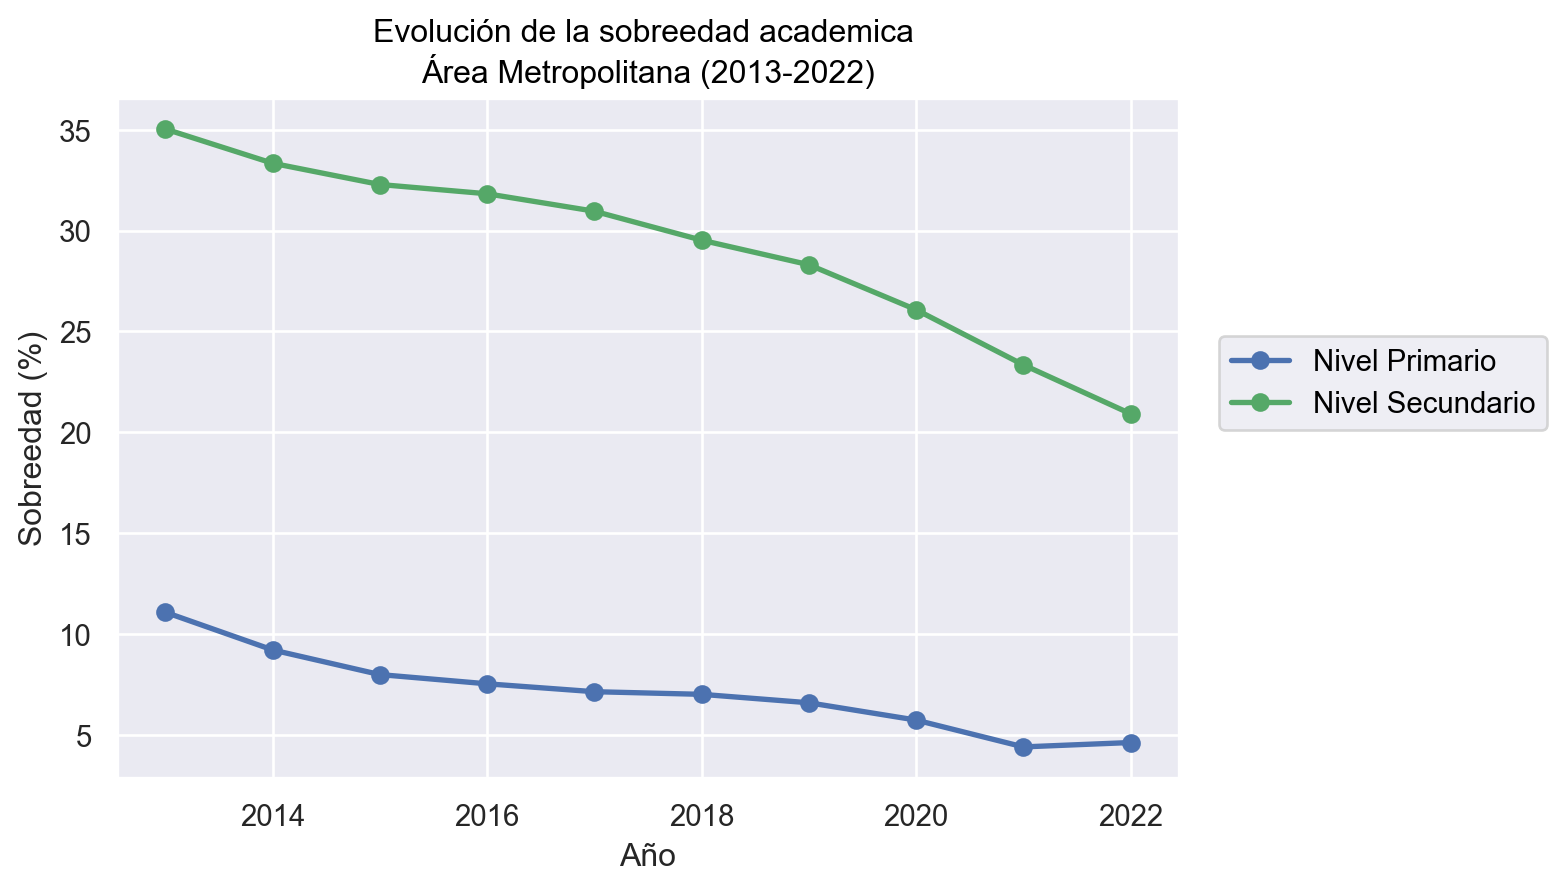

In [21]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="sobreedad_primaria",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="sobreedad_secundaria",label="Nivel Secundario")
    .label(title="Evolución de la sobreedad academica \nÁrea Metropolitana (2013-2022)",x="Año",y="Sobreedad (%)"))
    

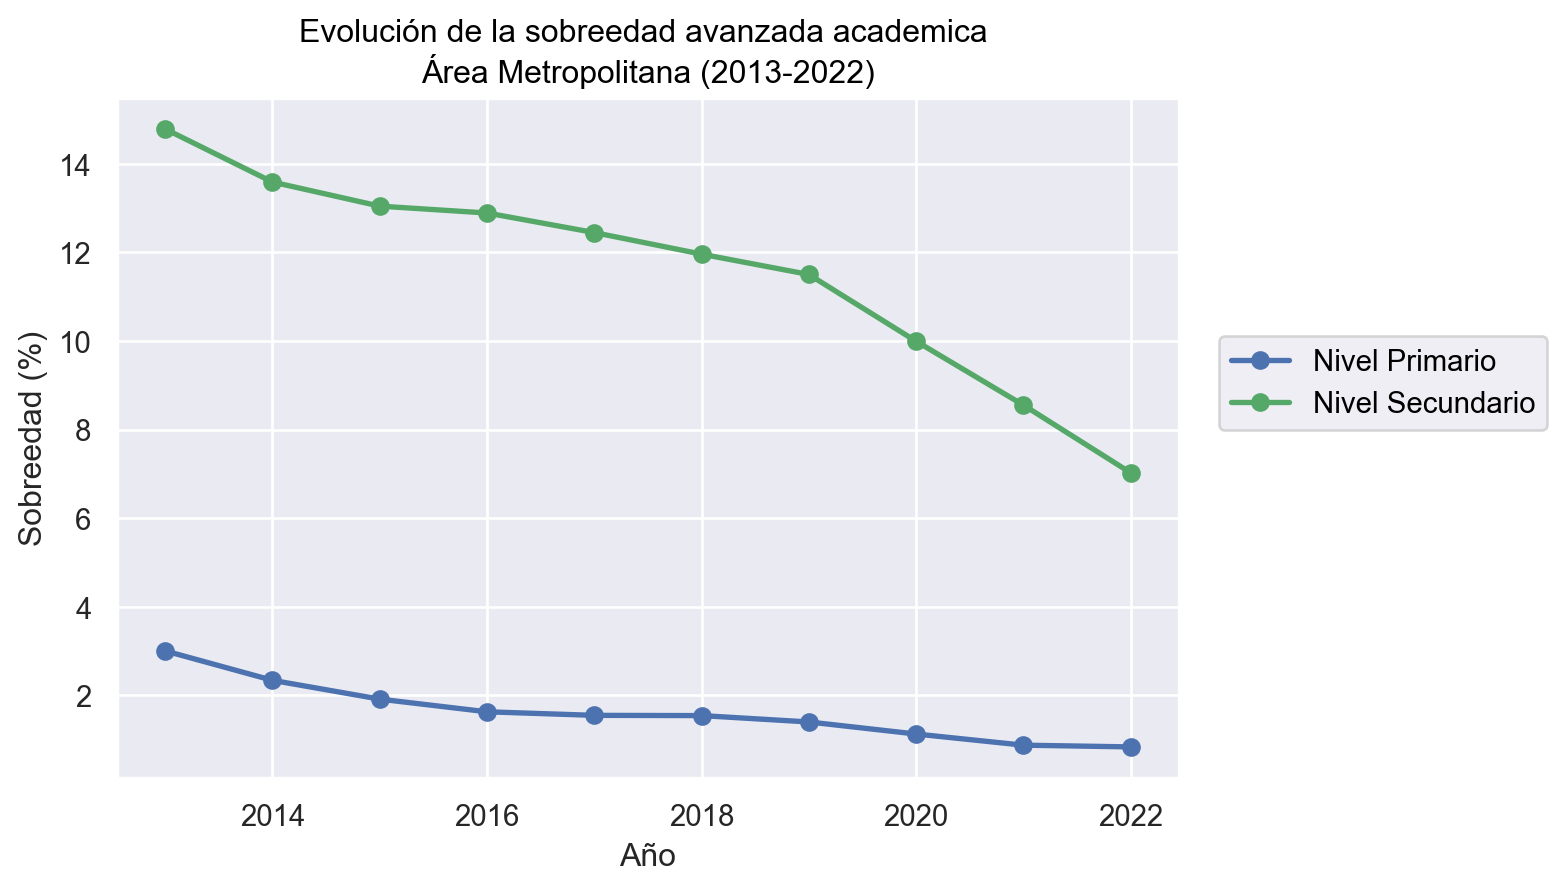

In [22]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="sobreedad_avanzada_primaria",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="sobreedad_avanzada_secundaria",label="Nivel Secundario")
    .label(title="Evolución de la sobreedad avanzada academica \nÁrea Metropolitana (2013-2022)",x="Año",y="Sobreedad (%)"))

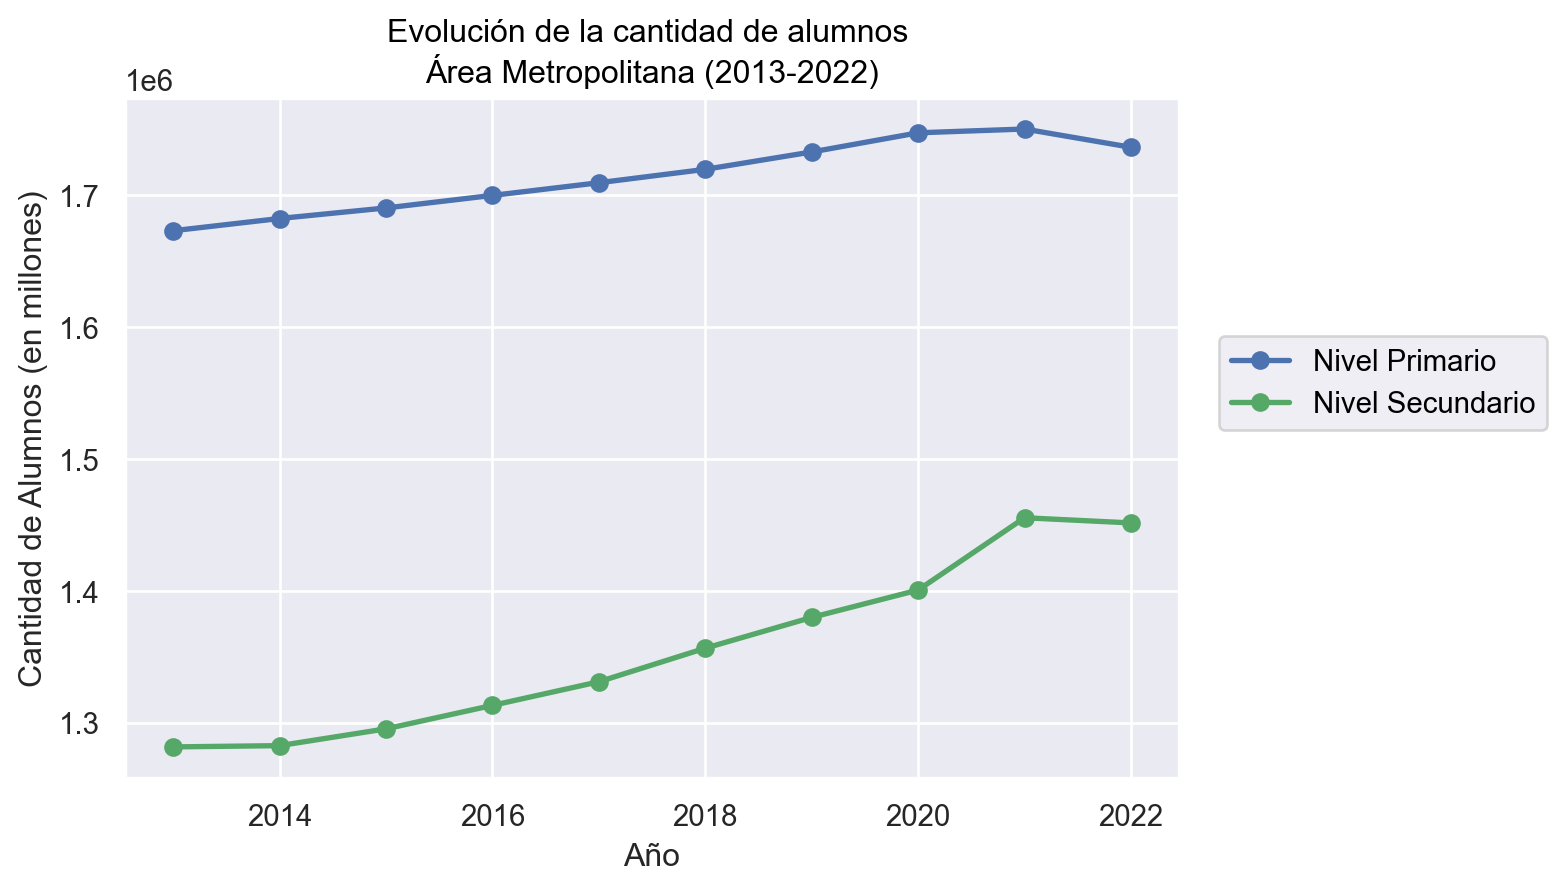

In [23]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="matricula_primario",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="matricula_secundario",label="Nivel Secundario")
    .label(title="Evolución de la cantidad de alumnos \nÁrea Metropolitana (2013-2022)",x="Año",y="Cantidad de Alumnos (en millones)"))

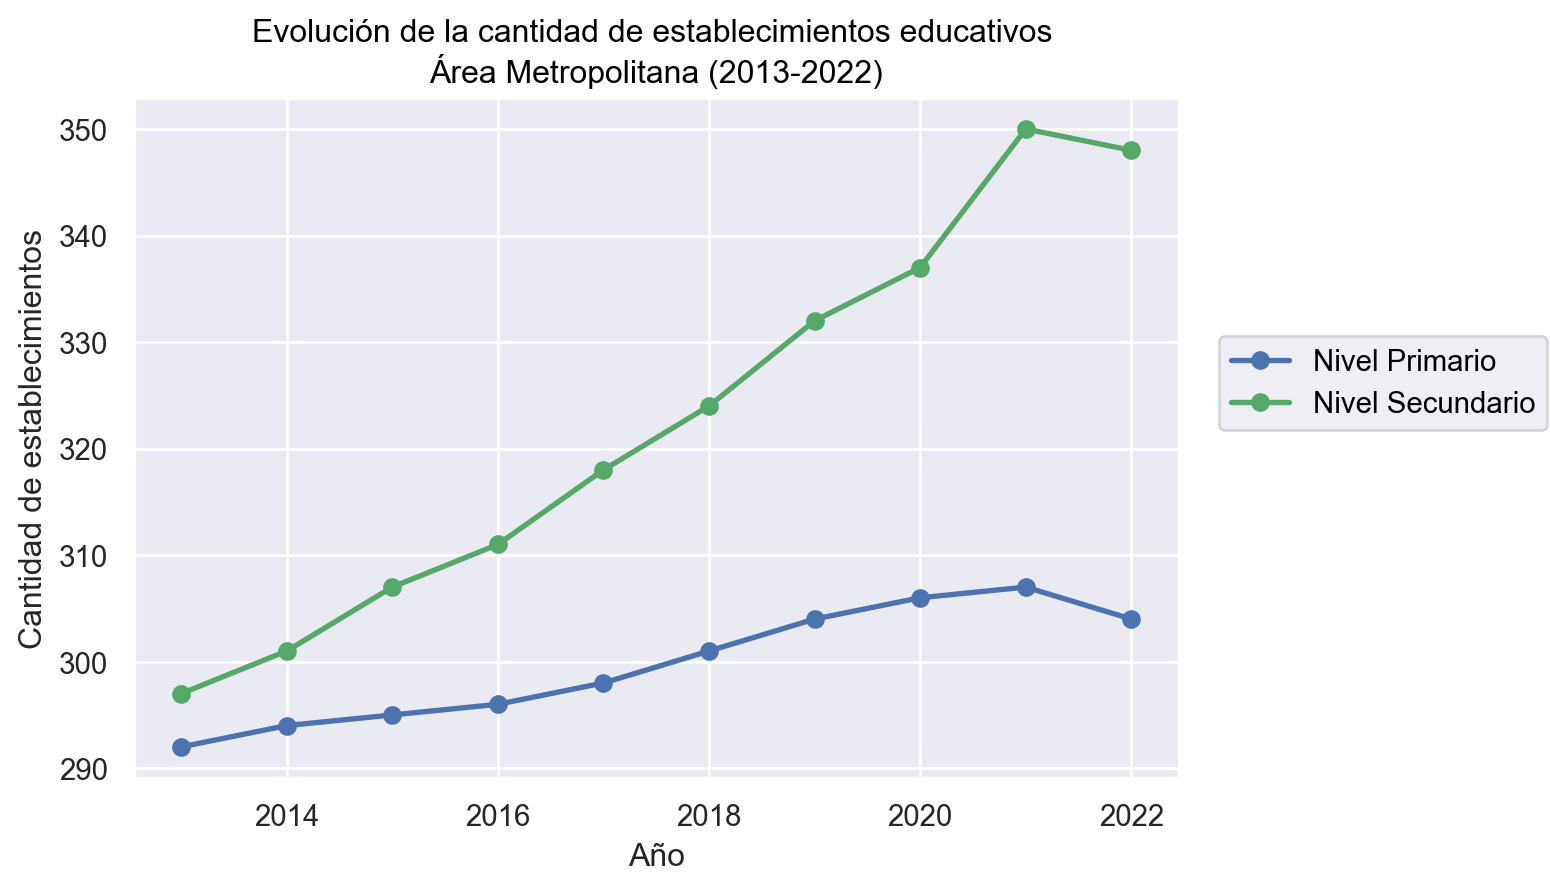

In [24]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="colegios_primario",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="colegios_secundario",label="Nivel Secundario")
    .label(title="Evolución de la cantidad de establecimientos educativos \nÁrea Metropolitana (2013-2022)",x="Año",y="Cantidad de establecimientos"))

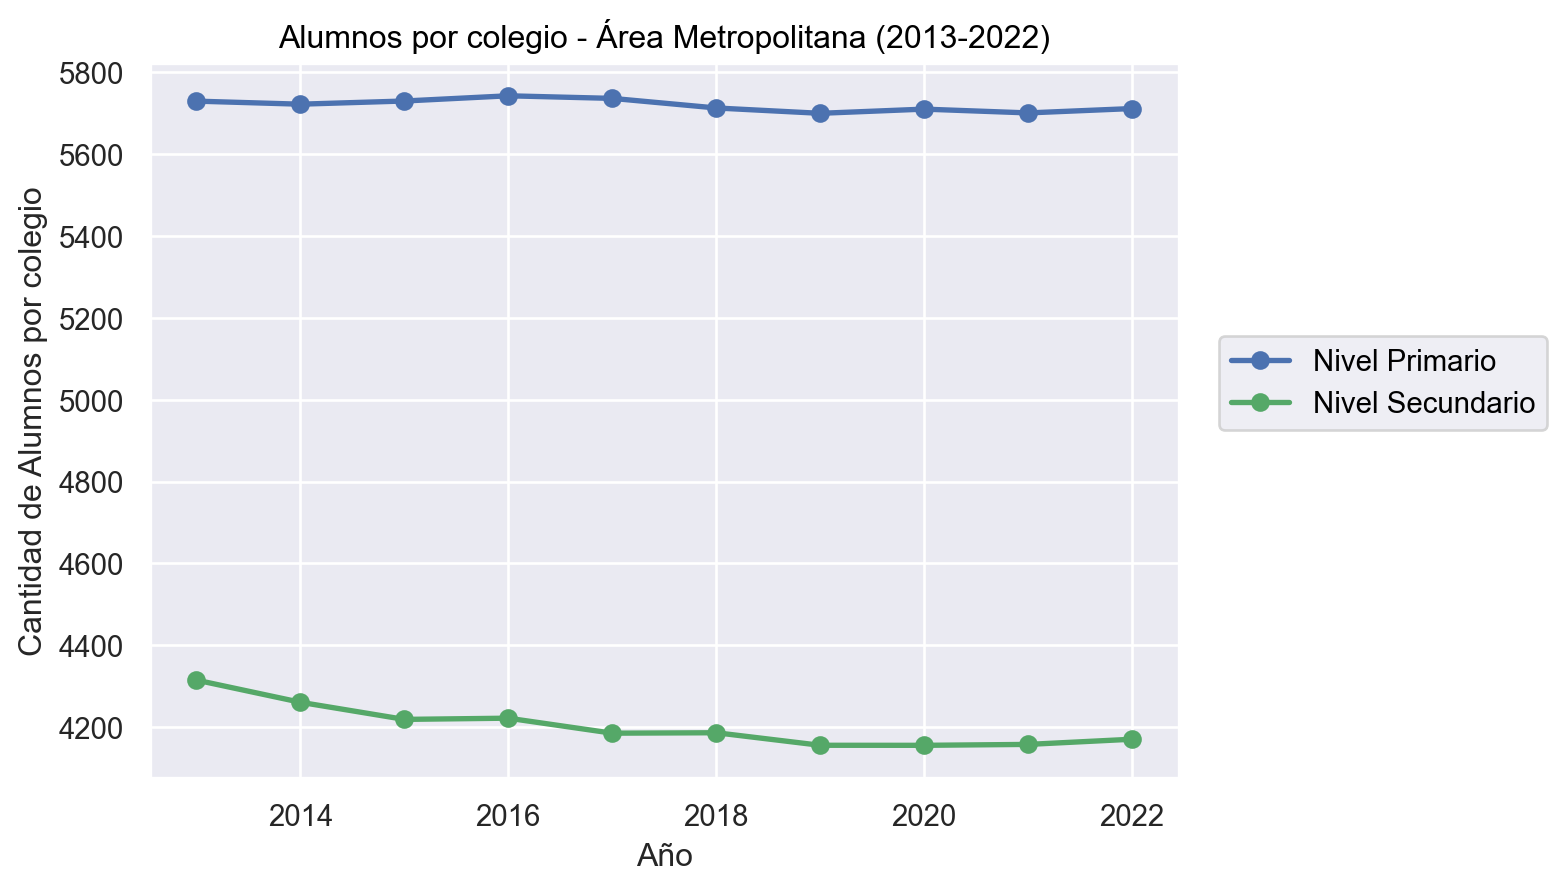

In [25]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y=df_investigacion["matricula_primario"]/df_investigacion["colegios_primario"],label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y=df_investigacion["matricula_secundario"]/df_investigacion["colegios_secundario"],label="Nivel Secundario")
    .label(title="Alumnos por colegio - Área Metropolitana (2013-2022)",x="Año",y="Cantidad de Alumnos por colegio"))

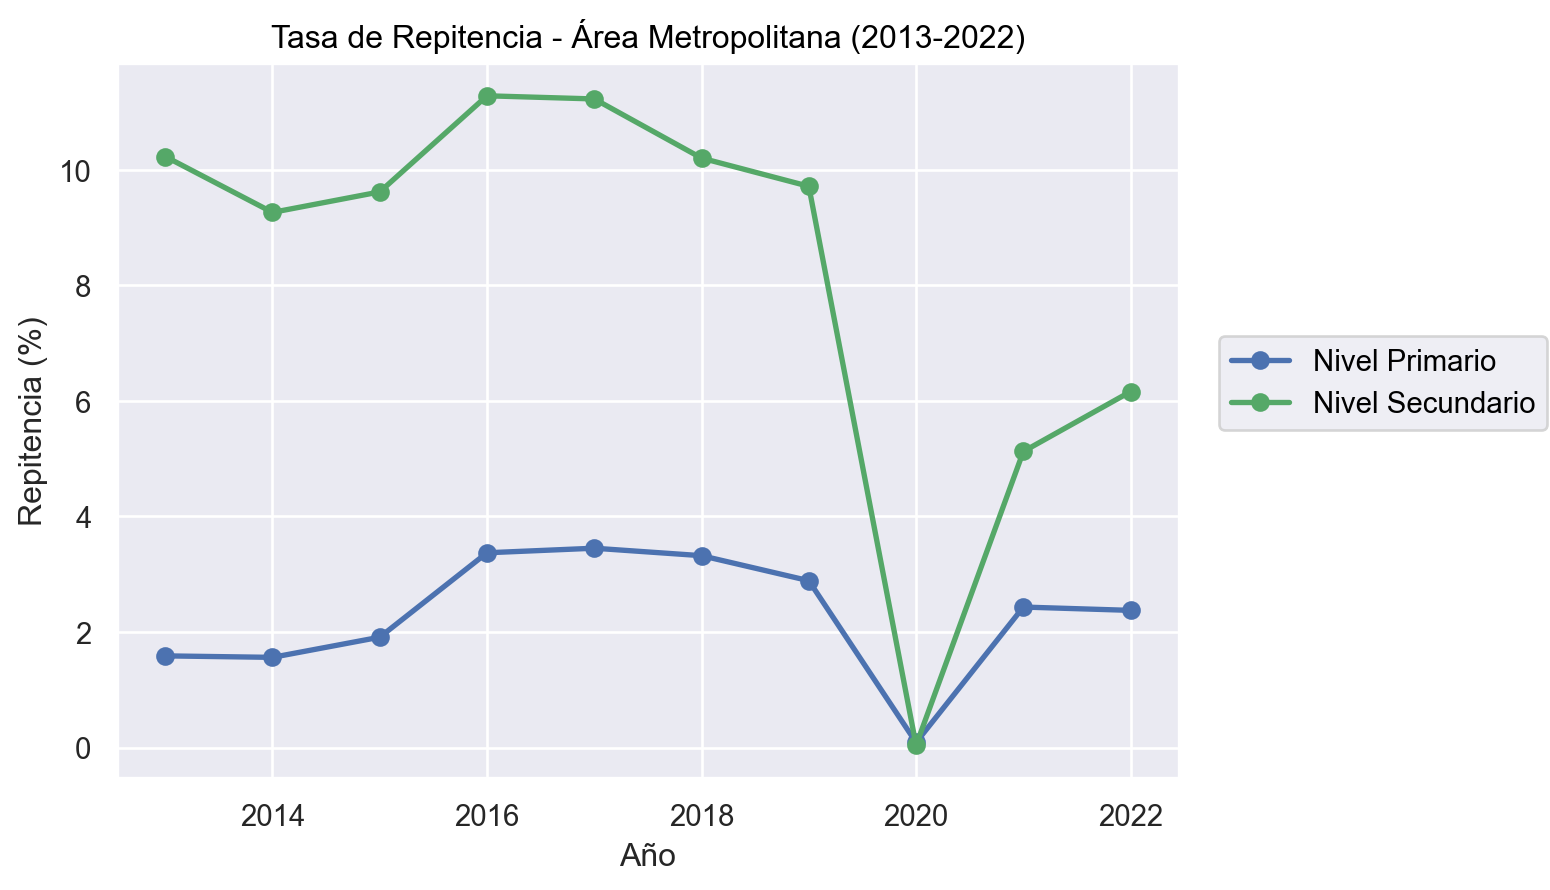

In [26]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="repitencia_primaria",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="repitencia_secundaria",label="Nivel Secundario")    
    .label(title="Tasa de Repitencia - Área Metropolitana (2013-2022)",y="Repitencia (%)",x="Año"))

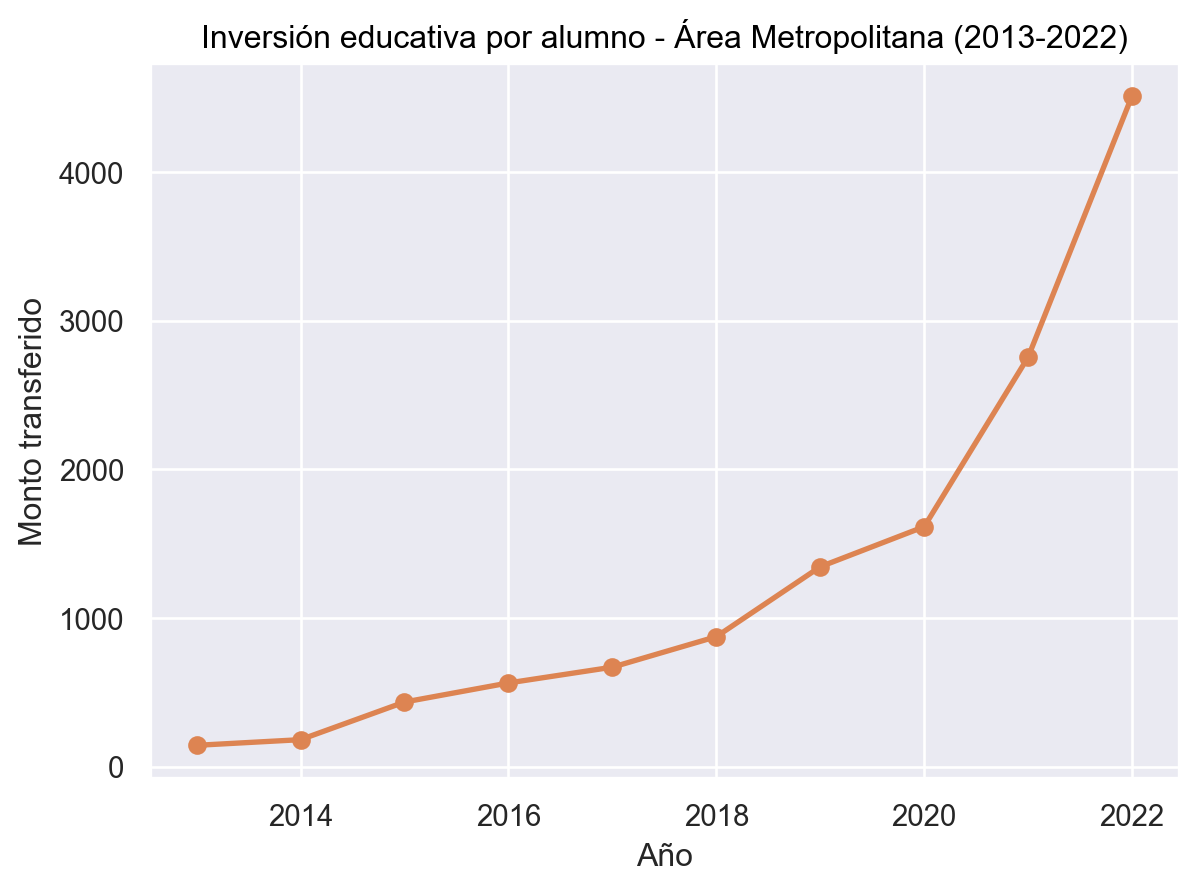

In [27]:
df_investigacion["matricula_total"]=df_investigacion["matricula_primario"]+df_investigacion["matricula_secundario"]+df_investigacion["matricula_nivel_inicial"]
df_investigacion["inversion_alumno"]=(df_investigacion["inversion_educativa"]/df_investigacion["matricula_total"])
df_investigacion["inversion_total_total"]=(df_investigacion["inversion_total"]/df_investigacion["poblacion"])

(so.Plot(df_investigacion,x="anio",y="inversion_alumno")
    .add(so.Line(marker="o",color="C1",linewidth=2))
    .label(title="Inversión educativa por alumno - Área Metropolitana (2013-2022)",x="Año",y="Monto transferido"))    

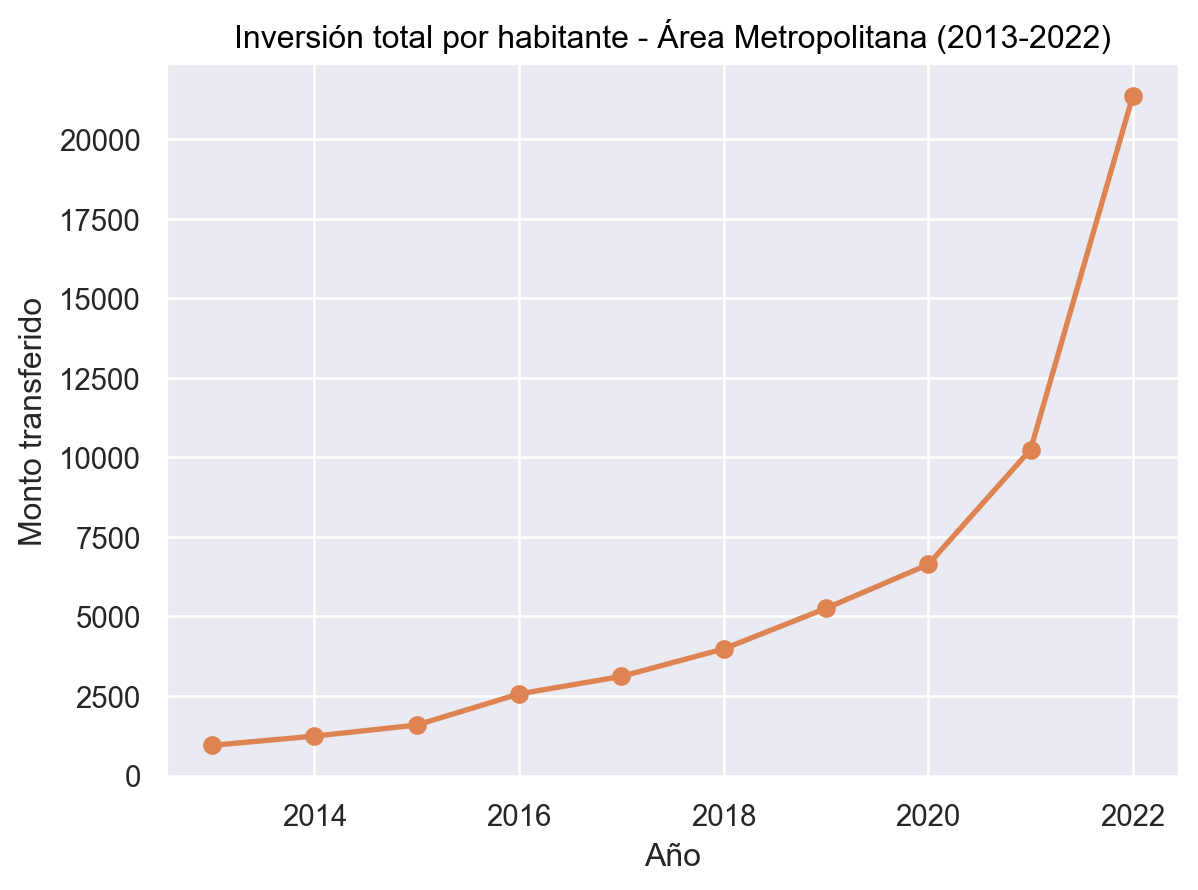

In [28]:
(so.Plot(df_investigacion,x="anio",y="inversion_total_total")
    .add(so.Line(marker="o",color="C1",linewidth=2))
    .label(title="Inversión total por habitante - Área Metropolitana (2013-2022)",x="Año",y="Monto transferido"))  

**PREDICCION REPITENCIA**

**Modelo de prediccion de repitencia pnivel primario no regularizado, en base a los datos mas relevantes para explicar la repitencia**

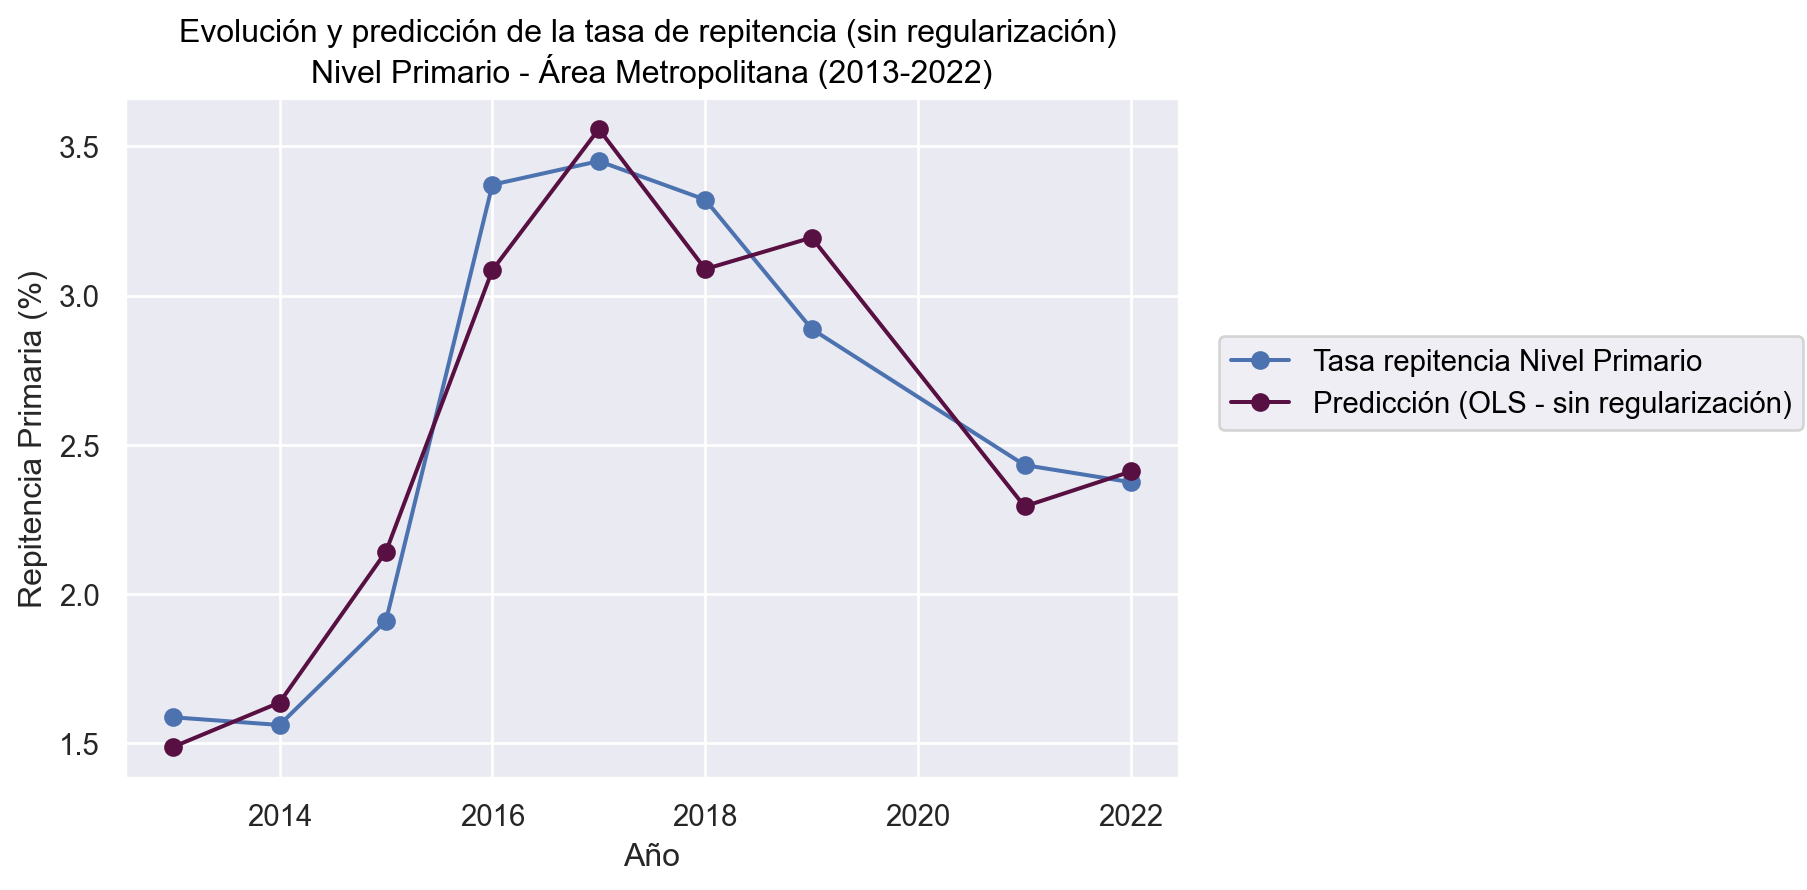

In [29]:
df_investigacion=df_investigacion[df_investigacion["anio"]!=2020].copy()

y,X=Formula('repitencia_primaria ~ anio + unidades_de_servicio_nivel_primario + matricula_primario + inversion_alumno + inversion_total_total + sobreedad_primaria + sobreedad_avanzada_primaria').get_model_matrix(df_investigacion)
modelo=linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_primaria",label="Tasa repitencia Nivel Primario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (OLS - sin regularización)")
    .label(title="Evolución y predicción de la tasa de repitencia (sin regularización) \nNivel Primario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Primaria (%)"))

***Busco regularizar mi modelo ya que noto presencia de overfitting***

***K FOLD VALIDATION - Dado el tamaño reducido de la serie temporal, se utilizó TimeSeriesSplit con pocos folds para asegurar conjuntos de entrenamiento informativos y evitar inestabilidad en los primeros splits. Uso regresión ridge para encontrar el alpha optimo***

In [30]:
tscv = TimeSeriesSplit(n_splits=3)

alphas = np.arange(0,50,1)
error_alphas=np.zeros(len(alphas))

for counter,alpha in enumerate(alphas):
    rmse = np.zeros(tscv.get_n_splits())
    modeloRidge=linear_model.Ridge(alpha=alpha,fit_intercept=False,solver="svd")
    ind=0

    for train_index, val_index in tscv.split(X):
        X_train, X_val, y_train, y_val=X.iloc[train_index],X.iloc[val_index],y.iloc[train_index],y.iloc[val_index]
        modeloRidge.fit(X_train,y_train)

        y_pred=modeloRidge.predict(X_val)
        rmse[ind]=np.sqrt(mean_squared_error(y_val,y_pred))
        ind=ind+1 
    error_alphas[counter] = np.median(rmse)

error_alphas

array([4.29025142, 2.89715843, 2.61757557, 2.49779886, 2.43125988,
       2.38890267, 2.35955886, 2.33801958, 2.32152856, 2.30849071,
       2.29791894, 2.28916968, 2.28180543, 2.27551837, 2.27008564,
       2.26534191, 2.26116197, 2.25744922, 2.25412796, 2.25113803,
       2.24843101, 2.24596749, 2.24371505, 2.24164683, 2.23974032,
       2.23797655, 2.23633943, 2.23481518, 2.23339199, 2.23205962,
       2.2308092 , 2.22963296, 2.2285241 , 2.22747663, 2.22648525,
       2.22554527, 2.2246525 , 2.2238032 , 2.22299402, 2.22222195,
       2.22148426, 2.22077852, 2.2201025 , 2.21945418, 2.21883171,
       2.21823343, 2.2176578 , 2.21710342, 2.216569  , 2.21605336])

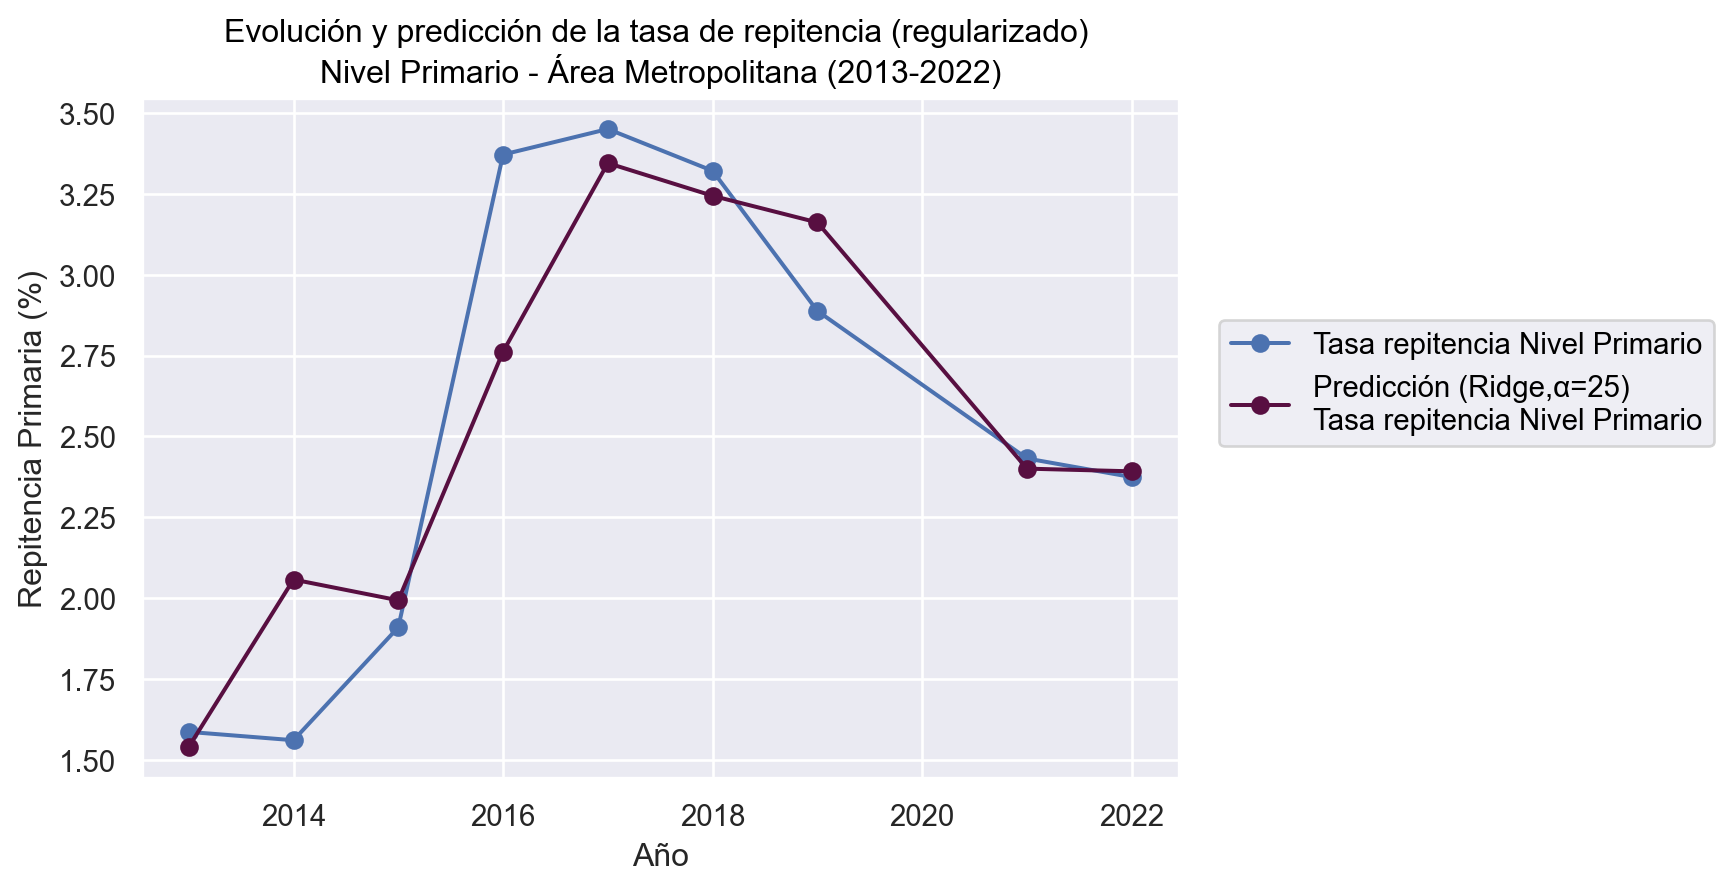

In [31]:
alpha_optimo=alphas[25]
y,X=Formula('repitencia_primaria ~ anio + unidades_de_servicio_nivel_primario + matricula_primario + inversion_total_total+ inversion_alumno + sobreedad_primaria + sobreedad_avanzada_primaria').get_model_matrix(df_investigacion)
modelo=linear_model.Ridge(alpha=alpha_optimo,fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_primaria",label="Tasa repitencia Nivel Primario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (Ridge,α=25) \nTasa repitencia Nivel Primario")
    .label(title="Evolución y predicción de la tasa de repitencia (regularizado) \nNivel Primario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Primaria (%)"))

In [32]:
#EERROR R2
print(r2_score(y,y_pred))

0.8418292194386127


**Modelo de prediccion de repitencia nivel secundario no regularizado, en base a los datos mas relevantes para explicar la repitencia**

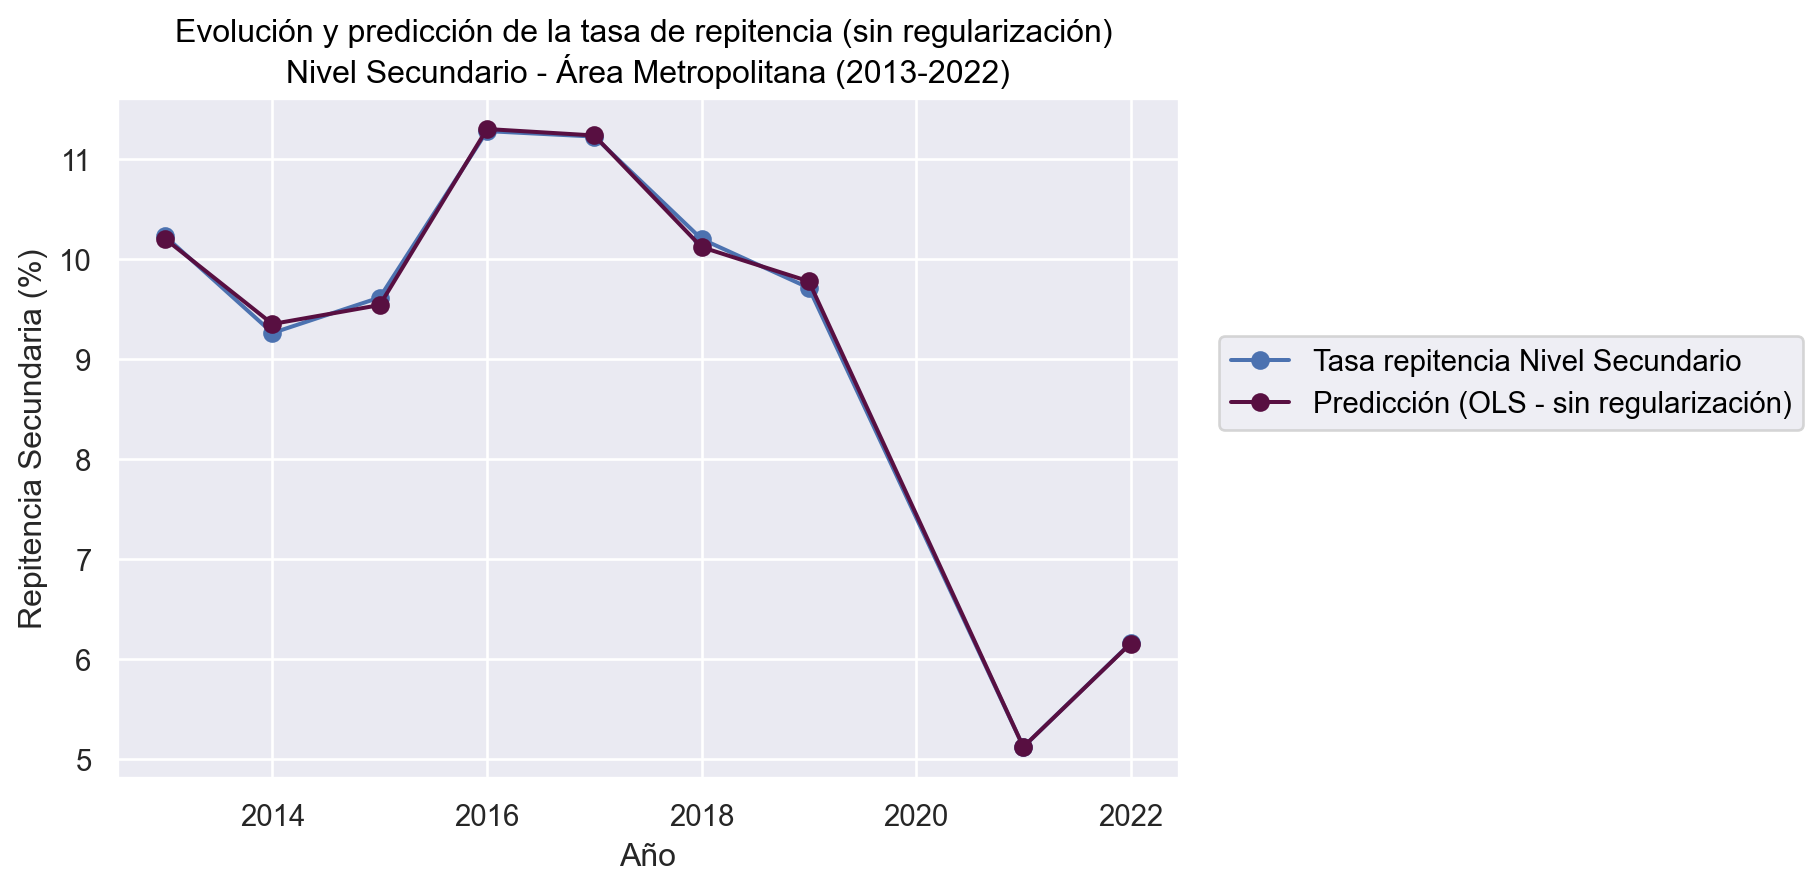

In [33]:
df_investigacion=df_investigacion.rename(columns={"unidades_de_servicio_nivel_secundario**":"unidades_servicio_secundario"})

y,X=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno +inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_investigacion)
modelo=linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_secundaria",label="Tasa repitencia Nivel Secundario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (OLS - sin regularización)")
    .label(title="Evolución y predicción de la tasa de repitencia (sin regularización) \nNivel Secundario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Secundaria (%)"))

***Busco regularizar mi modelo ya que noto presencia de overfitting***

***K FOLD VALIDATION - Dado el tamaño reducido de la serie temporal, se utilizó TimeSeriesSplit con pocos folds para asegurar conjuntos de entrenamiento informativos y evitar inestabilidad en los primeros splits. Uso regresión ridge para encontrar el alpha optimo***

In [34]:
tscv = TimeSeriesSplit(n_splits=3)

alphas = np.arange(0,80,1)
error_alphas=np.zeros(len(alphas))

for counter,alpha in enumerate(alphas):
    rmse = np.zeros(tscv.get_n_splits())
    modeloRidge=linear_model.Ridge(alpha=alpha,fit_intercept=False,solver="svd")
    ind=0

    for train_index, val_index in tscv.split(X):
        X_train, X_val, y_train, y_val=X.iloc[train_index],X.iloc[val_index],y.iloc[train_index],y.iloc[val_index]
        modeloRidge.fit(X_train,y_train)

        y_pred=modeloRidge.predict(X_val)
        rmse[ind]=np.sqrt(mean_squared_error(y_val,y_pred))
        ind=ind+1
    error_alphas[counter] = np.median(rmse)
error_alphas

array([5.47335851, 5.47279255, 5.4722268 , 5.47166129, 5.47109599,
       5.47053092, 5.46996608, 5.46940145, 5.46883705, 5.46827288,
       5.46770892, 5.46714519, 5.46658168, 5.4660184 , 5.46545534,
       5.46489249, 5.46432988, 5.46376748, 5.4632053 , 5.46264335,
       5.46208162, 5.46152011, 5.46095882, 5.46039775, 5.45983691,
       5.45927628, 5.45871588, 5.45815569, 5.45759573, 5.45703599,
       5.45647646, 5.45591716, 5.45535808, 5.45479922, 5.45424057,
       5.45368215, 5.45312395, 5.45256596, 5.4520082 , 5.45145065,
       5.45089333, 5.45033622, 5.44977933, 5.44922266, 5.44866621,
       5.44810997, 5.44755396, 5.44699816, 5.44644258, 5.44588722,
       5.44533208, 5.44477715, 5.44422244, 5.44366795, 5.44311368,
       5.44255962, 5.44200578, 5.44145215, 5.44089875, 5.44034556,
       5.43979258, 5.43923983, 5.43868729, 5.43813496, 5.43758285,
       5.43703096, 5.43647928, 5.43592782, 5.43537657, 5.43482554,
       5.43427472, 5.43372412, 5.43317373, 5.43262356, 5.43207

**Regresion Ridge**

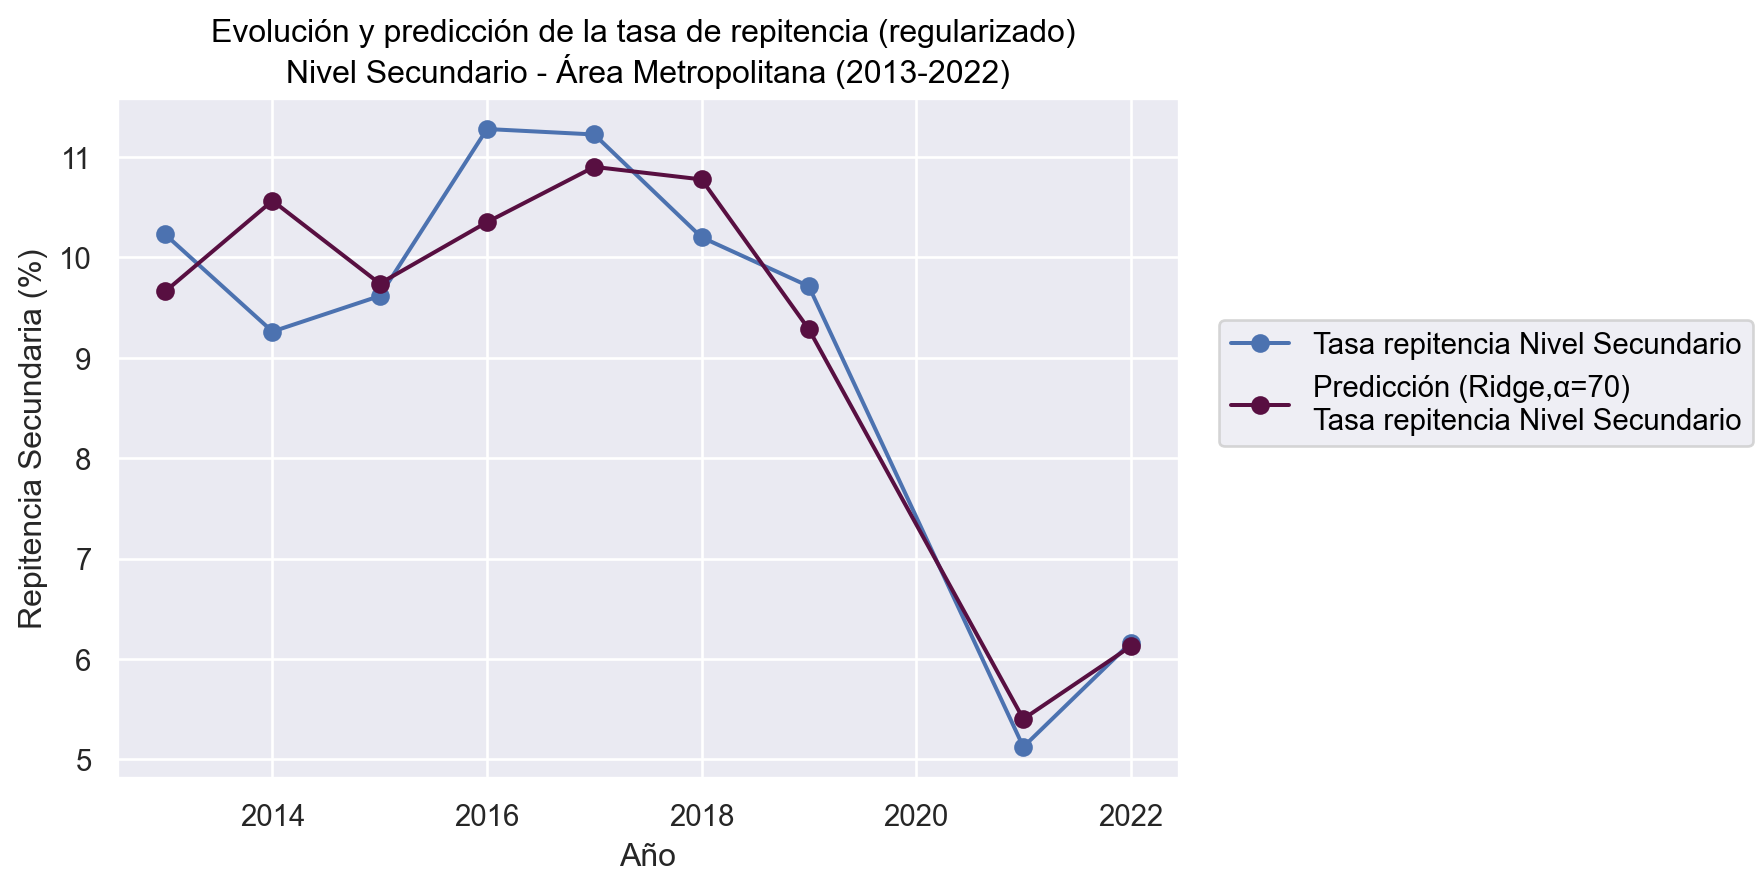

In [35]:
alpha_optimo=alphas[69]

y,X=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno + inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_investigacion)
modelo=linear_model.Ridge(alpha=alpha_optimo,fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_secundaria",label="Tasa repitencia Nivel Secundario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (Ridge,α=70) \nTasa repitencia Nivel Secundario")
    .label(title="Evolución y predicción de la tasa de repitencia (regularizado) \nNivel Secundario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Secundaria (%)"))

In [36]:
#ERROR R2
r2_score(y,y_pred)

0.9022363721999391

**VERIFICO QUE TAN OPTIMO ES MI MODELO PREDICTORIO DE REPITENCIA NIVEL SECUNDARIO**

In [37]:
df_train=df_investigacion[df_investigacion["anio"]<=2019]
df_test=df_investigacion[df_investigacion["anio"]>2019] 

In [38]:
alpha_optimo=alphas[70]

y,X=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno + inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_train)
modelo=linear_model.Ridge(alpha=alpha_optimo,fit_intercept=False)
modelo.fit(X,y)

y1,X1=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno + inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_test)

y_pred=modelo.predict(X1)
r2_score(y1,y_pred)

-222.765531609064

El conjunto de entrenamiento corresponde a años prepandemia, mientras que el conjunto de test incluye datos posteriores a la pandemia. Este quiebre temporal introduce un cambio estructural en el fenómeno estudiado, lo que explica el bajo desempeño predictivo del modelo fuera de muestra. La incorporación de datos correspondientes al período 2021–2025 permitiría capturar la nueva dinámica estructural posterior a la pandemia, reduciendo el desajuste entre los conjuntos de entrenamiento y test y mejorando la capacidad predictiva del modelo